# About

The purpose of this notebook is to showcase techniques and methods used to better understand and explain the predictions made by both linear and non-linear predictive models. Some transformation and analysis is done to reduce the error scores, but the goal is not to create the best model. The goal is to practically apply explainability techniques.

# Import Libraries, Functions, and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap
import random
warnings.simplefilter(action='ignore')

The source of the data comes from Kaggle and can be found here: https://www.kaggle.com/datasets/fatihilhan/global-superstore-dataset

In [2]:
df = pd.read_excel("/Users/spencershaw/downloads/superstore.xlsx")
df.head()

,Category,City,Country,Customer.ID,Customer.Name,Discount,Market,ËÆ∞ÂΩïÊï∞,Order.Date,Order.ID,...,Sales,Segment,Ship.Date,Ship.Mode,Shipping.Cost,State,Sub.Category,Year,Market2,weeknum
0,Office Supplies,Los Angeles,United States,LS-172304,Lycoris Saunders,0.0,US,1,2011-01-07,CA-2011-130813,...,19,Consumer,2011-01-09,Second Class,4.37,California,Paper,2011,North America,2
1,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,2011-01-21,CA-2011-148614,...,19,Consumer,2011-01-26,Standard Class,0.94,California,Paper,2011,North America,4
2,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05,CA-2011-118962,...,21,Consumer,2011-08-09,Standard Class,1.81,California,Paper,2011,North America,32
3,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,2011-08-05,CA-2011-118962,...,111,Consumer,2011-08-09,Standard Class,4.59,California,Paper,2011,North America,32
4,Office Supplies,Los Angeles,United States,AP-109154,Arthur Prichep,0.0,US,1,2011-09-29,CA-2011-146969,...,6,Consumer,2011-10-03,Standard Class,1.32,California,Paper,2011,North America,40


In [3]:
# Split our data
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2)
o_train, o_test = train.copy(), test.copy()
print(f"Number of records in 'train': {len(train)}")
print(f"Number of records in 'test': {len(test)}")

Number of records in 'train': 41032
Number of records in 'test': 10258


# EDA

In [4]:
# In our original dataset, how many values are missing?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Category        51290 non-null  object        
 1   City            51290 non-null  object        
 2   Country         51290 non-null  object        
 3   Customer.ID     51290 non-null  object        
 4   Customer.Name   51290 non-null  object        
 5   Discount        51290 non-null  float64       
 6   Market          51290 non-null  object        
 7   ËÆ∞ÂΩïÊï∞       51290 non-null  int64         
 8   Order.Date      51290 non-null  datetime64[ns]
 9   Order.ID        51290 non-null  object        
 10  Order.Priority  51290 non-null  object        
 11  Product.ID      51290 non-null  object        
 12  Product.Name    51290 non-null  object        
 13  Profit          51290 non-null  float64       
 14  Quantity        51290 non-null  int64         
 15  Re

In [5]:
# Let's drop indice number 7 and 16
df = df.drop(df.columns[[7, 16]], axis=1)
train = train.drop(train.columns[[7, 16]], axis=1)
test = test.drop(test.columns[[7, 16]], axis=1)

In [6]:
# What does our target variable look like?
df.Sales.describe()

count    51290.000000
mean       246.498440
std        487.567175
min          0.000000
25%         31.000000
50%         85.000000
75%        251.000000
max      22638.000000
Name: Sales, dtype: float64

In [7]:
# Create lists of object columns and numerical columns
num_cols = train.select_dtypes(include=['int', 'float']).columns.tolist()
obj_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Number of numerical columns in our dataset: {len(num_cols)}")
print(f"Number of object columns in our dataset: {len(obj_cols)}")

Number of numerical columns in our dataset: 7
Number of object columns in our dataset: 16


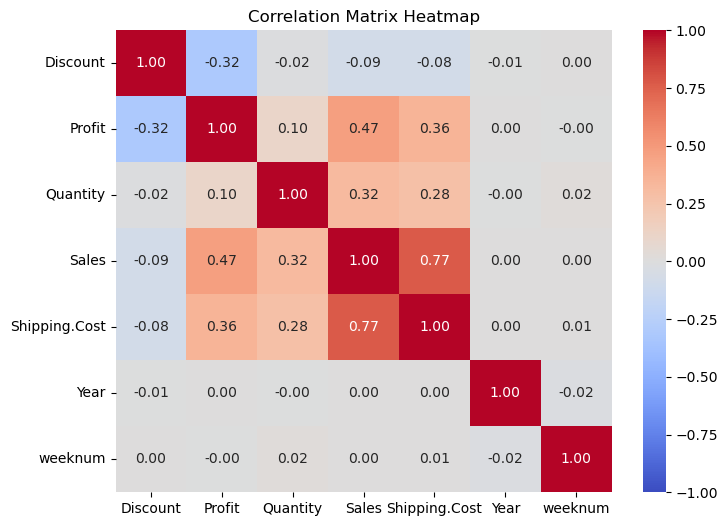

In [8]:
# Set up the heatmap with Seaborn
plt.figure(figsize=(8, 6))
correlation_matrix = train[num_cols].corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f")
# Set plot title
plt.title('Correlation Matrix Heatmap')
# Show the plot
plt.show()

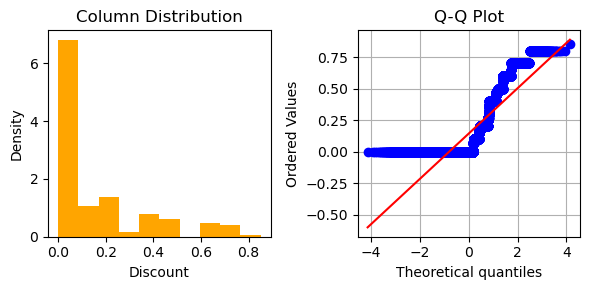

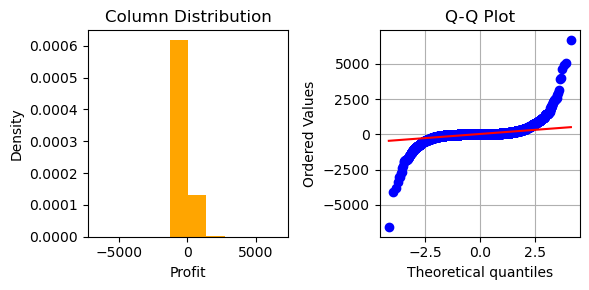

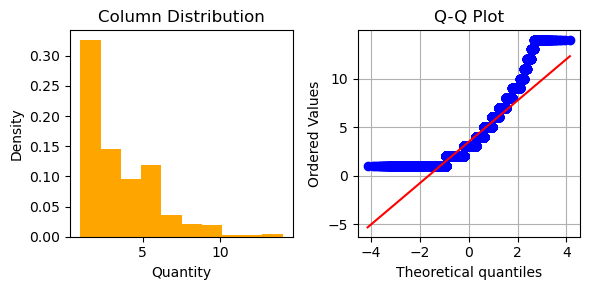

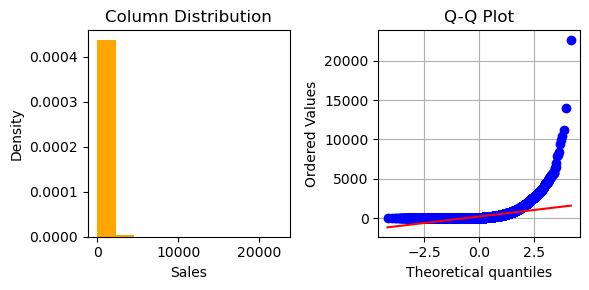

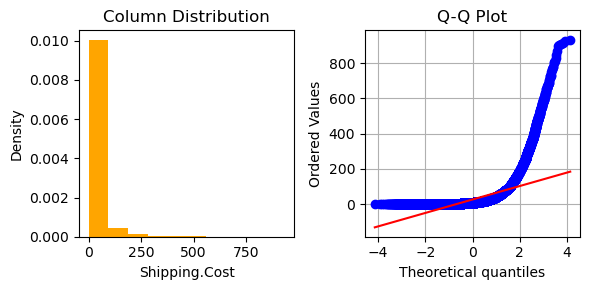

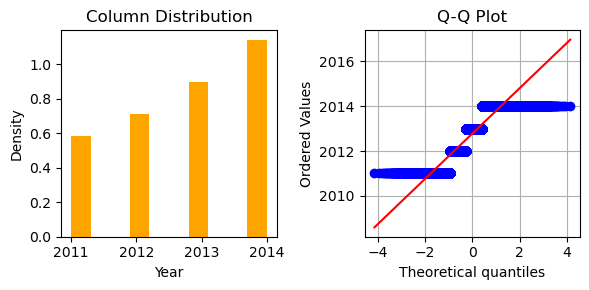

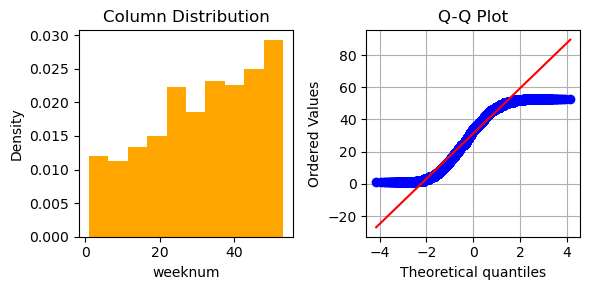

In [9]:
# Plot distribution curves and Q-Q plots 
from scipy import stats

for i in num_cols:
    plt.figure(figsize=(6,3))
    # Plot distributions
    plt.subplot(1,2,1)
    plt.hist(train[i], bins=10, density=True, color='orange')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.title("Column Distribution")
    # Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(train[i], plot=plt)
    plt.title('Q-Q Plot')
    # Configure graph aesthetics
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
# Object column EDA
for i in obj_cols:
    missing_count = train[i].isnull().sum()
    percent_missing = 100*round(missing_count/train.shape[0], 2)
    print(f"Missing count: {missing_count} ({percent_missing}%)")
    print(f"Number of unique values: {len(train[i].unique())}")
    print(f"{train[i].value_counts()}\n")

Missing count: 0 (0.0%)
Number of unique values: 3
Office Supplies    25007
Technology          8087
Furniture           7938
Name: Category, dtype: int64

Missing count: 0 (0.0%)
Number of unique values: 3511
New York City            731
Los Angeles              585
Philadelphia             415
San Francisco            400
Seattle                  355
                        ... 
Villeneuve-la-Garenne      1
El Escorial                1
The Colony                 1
Englewood                  1
Tirupati                   1
Name: City, Length: 3511, dtype: int64

Missing count: 0 (0.0%)
Number of unique values: 147
United States    7938
Australia        2279
France           2225
Mexico           2142
Germany          1680
                 ... 
South Sudan         2
Armenia             2
Chad                2
Bahrain             1
Slovenia            1
Name: Country, Length: 147, dtype: int64

Missing count: 0 (0.0%)
Number of unique values: 4810
JG-158051    35
BC-111252    31
PP-18955

***Object Columns Review***

To keep things relatively simple, let's implement an 80/20 rule. The bottom 20% of distributions will be replaced with "OTHER".

In [11]:
# Some columns it doesn't make sense to keep, so we will drop these and create a new obj_cols list
train = train.drop(['Customer.ID', 'Customer.Name', 'Order.Date', 'Order.ID',
                    'Product.ID', 'Product.Name', 'Ship.Date'], axis=1)
test = test.drop(['Customer.ID', 'Customer.Name', 'Order.Date', 'Order.ID',
                  'Product.ID', 'Product.Name', 'Ship.Date'], axis=1)

# Create a new_obj_cols list
new_obj_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Length of 'obj_cols': {len(obj_cols)}")
print(f"Length of 'new_obj_cols': {len(new_obj_cols)}")

Length of 'obj_cols': 16
Length of 'new_obj_cols': 11


In [12]:
total_records = train.shape[0] # Record the total number of records
threshold = 0.8 # Set a value of top 'threshold' to keep
for column in new_obj_cols:
    # If the number of unique values is less than 20, then don't change it
    if len(train[column].unique()) > 20:
        value_counts_values = train[column].value_counts().values # Record only the values for each index
        counter = 0 # Our iterable object through the loop
        # Count the number of elements until we reach the sum of 80%
        while value_counts_values[:counter].sum() <= round(total_records*threshold):
            counter += 1
            
        # Create the list indexed to the 'counter' variable and replace the 20% values with "OTHER"
        index_values_to_keep = train.City.value_counts().index[:counter].tolist()
        train[column] = np.where(train[column].isin(index_values_to_keep), train[column], 'OTHER')
        test[column] = np.where(test[column].isin(index_values_to_keep), test[column], 'OTHER')
    else:
        continue

# Model 1: Linear Regression

Linear Regression works best when each feature is normally distributed, so let's try and transform the column distributions based on our EDA results.

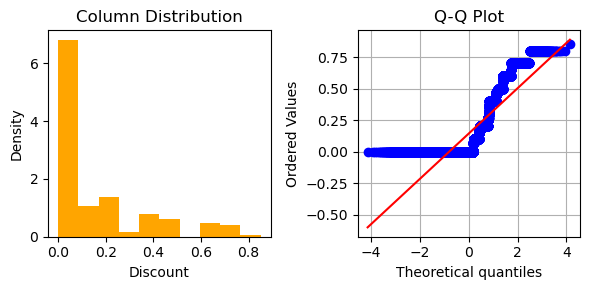

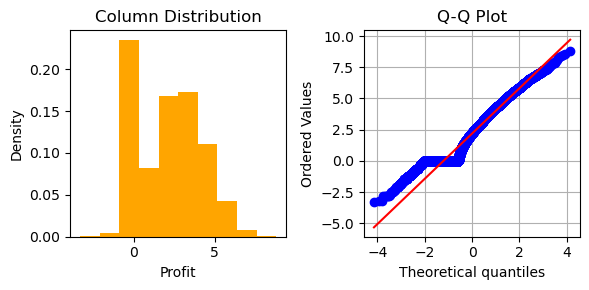

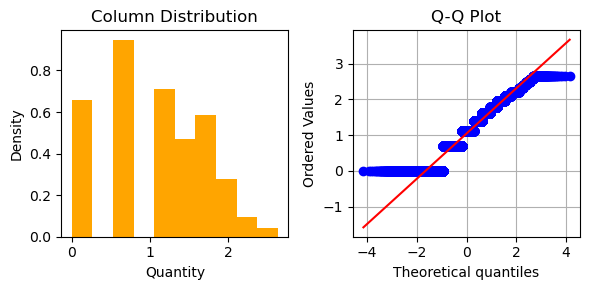

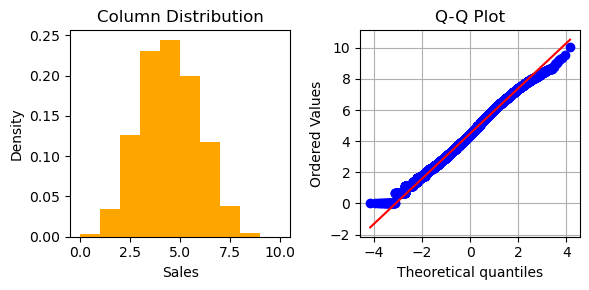

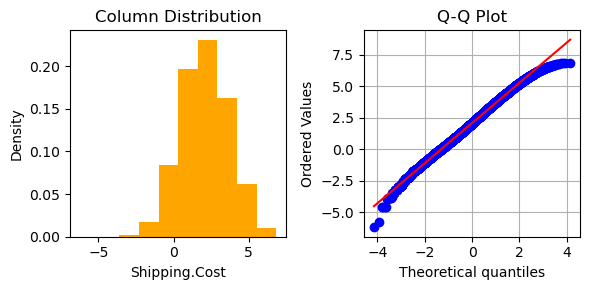

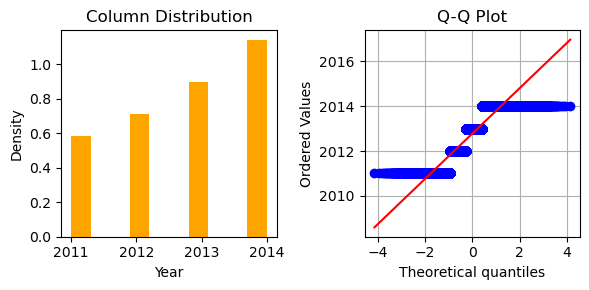

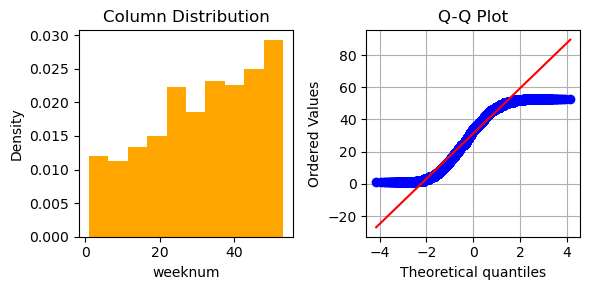

In [13]:
# Transform the columns to be similar to normal distributions
def linear_column_transformer(df):
    df['Profit'] = df.Profit.apply(np.log).replace([-np.inf, np.inf], 0).fillna(0)
    df['Quantity'] = df.Quantity.apply(np.log).replace([-np.inf, np.inf], 0).fillna(0)
    df['Sales'] = df.Sales.apply(np.log).replace([-np.inf, np.inf], 0).fillna(0)
    df['Shipping.Cost'] = df['Shipping.Cost'].apply(np.log).replace([-np.inf, np.inf], 0).fillna(0)
    return df
linear_train = linear_column_transformer(train)
linear_test = linear_column_transformer(test)

# Plot the graphs
for i in num_cols:
    plt.figure(figsize=(6,3))
    # Plot distributions
    plt.subplot(1,2,1)
    plt.hist(linear_train[i], bins=10, density=True, color='orange')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.title("Column Distribution")
    # Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(linear_train[i], plot=plt)
    plt.title('Q-Q Plot')
    # Configure graph aesthetics
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
# Create X and y sets
linear_train_X = linear_train.drop(['Profit', 'Sales'], axis=1) # Drop 'Profit' due to target leakage
linear_test_X = linear_test.drop(['Profit', 'Sales'], axis=1)
linear_train_y = linear_train[['Sales']]
linear_test_y = linear_test[['Sales']]

# Create 'new_num_cols' list
new_num_cols = linear_train_X.select_dtypes(include=['float', 'int']).columns.tolist()

In [15]:
# Now that column distributions are more normalized, it's still good practice to standardize the values
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
linear_train_X[new_num_cols] = std.fit_transform(linear_train_X[new_num_cols])
linear_test_X[new_num_cols] = std.transform(linear_test_X[new_num_cols])

In [16]:
# One hot encode variables
linear_train_X = pd.get_dummies(linear_train_X)
linear_test_X = pd.get_dummies(linear_test_X)
for i in set(linear_train_X.columns) - set(linear_test_X.columns):
    linear_test_X[i] = 0

In [17]:
# Fix the order of the columns
linear_test_X = linear_test_X[linear_train_X.columns]

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

model_1 = LinearRegression()
model_1.fit(linear_train_X, linear_train_y)
print(f"Train RMSE: {round(mse(linear_train_y, model_1.predict(linear_train_X), squared=False), 2)}")
print(f"Test RMSE: {round(mse(linear_test_y, model_1.predict(linear_test_X), squared=False), 2)}")

Train RMSE: 0.43
Test RMSE: 268663017.06


In [19]:
weights_matrix = pd.DataFrame(model_1.coef_, columns=linear_train_X.columns).T.rename(columns={0:'Weights'})
print(f"Model bias term: {model_1.intercept_}\n")
weights_matrix.sort_values('Weights', ascending=False)

Model bias term: [2.62692814e+11]



,Weights
Sub.Category_Copiers,1.483267e+12
Sub.Category_Machines,1.483267e+12
Sub.Category_Phones,1.483267e+12
Sub.Category_Accessories,1.483267e+12
Market2_North America,9.577675e+11
...,...
Sub.Category_Chairs,-5.693273e+11
Sub.Category_Furnishings,-5.693273e+11
Market_US,-6.639440e+11
Category_Office Supplies,-7.485455e+11


In [20]:
weights_matrix[(weights_matrix.Weights <= 100) & (weights_matrix.Weights >= -100)]

,Weights
Discount,-8.893307e-02
Quantity,2.183211e-01
Shipping.Cost,1.071361e+00
Year,1.942574e-06
weeknum,2.627891e-03
Country_OTHER,-1.804112e-16


In [21]:
# Create a list of the column names
condensed_features = weights_matrix[(weights_matrix.Weights <= 100) & (weights_matrix.Weights >= -100)].index.tolist()

# Model 1.1: Linear Regression with Reduced Features

The weights matrix had some extremely illogical values. So let's try another linear regression model, this time only keeping the columns that had a weight between -100 and 100

In [22]:
linear_train_X_condensed = linear_train_X[condensed_features]
linear_test_X_condensed = linear_test_X[condensed_features]

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

model_11 = LinearRegression()
model_11.fit(linear_train_X_condensed, linear_train_y)
print(f"Train RMSE: {round(mse(linear_train_y, model_11.predict(linear_train_X_condensed), squared=False), 2)}")
print(f"Test RMSE: {round(mse(linear_test_y, model_11.predict(linear_test_X_condensed), squared=False), 2)}")

Train RMSE: 0.59
Test RMSE: 0.59


In [24]:
# What does our transformed target variable look like?
linear_train_y.describe()

,Sales
count,41032.000000
mean,4.489692
std,1.454918
min,0.000000
25%,3.433987
50%,4.454347
75%,5.529429
max,10.027385


## Linear Model Explainability

In [25]:
weights_matrix_condensed = pd.DataFrame(model_11.coef_, columns=linear_train_X_condensed.columns).T.rename(columns={0:'Weights'})
print(f"Model bias term: {model_11.intercept_}\n")
weights_matrix_condensed.sort_values('Weights', ascending=False)

Model bias term: [4.48969206]



,Weights
Shipping.Cost,1.256438
Quantity,0.138258
Year,0.003034
Country_OTHER,0.000000
weeknum,-0.000738
Discount,-0.057287


***Shapley (Shap) Values***

Shapely values are a widely used approach to explain the outputs from machine learning models. Shap values can give insights into how the model is training, and a logical depiction of how the model predicted the way it did. Shap values are derived from *cooperative game theory*.
> "The Shapley value is a solution concept used in game theory that involves fairly distributing both gains and costs to several actors working in a coalition. Game theory is when two or more players are involved in a strategy to achieve a desired outcome or payoff." (https://investopedia.com/terms/s/shapley-value.asp#:~:text=The%20Shapley%20value%20is%20a,a%20desired%20outcome%20or%20payoff)

> "The core idea behind Shapley value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model's output among its input features." (https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)

> IMPORTANT NOTE: Shap values DO NOT tell you how good the predictions are, it only tells you HOW it got to that prediction.

Key components of Shap values:
1. Expected Value (E[f(x)]) - is the average of all predictions.
    * Shap values start by expecting the average outcome then shows how each 'player', feature, played a part in the difference between the expected outcome and the actual outcome (f(x)).
    * They [Shap values] explain how to get from the base value E[f(x)] that would be predicted if we did not know any features to the current output f(x).
2. Current output (f(x)) - represents the predicted value for each instance in the dataset.

<u>**NOTE:**</u> An extremely insightful aspect of shap values, is the magnitude of each feature's contribution. Most features will be more important or less important depending on its value. Discount for example we will see (especially in the XGBoost model), has more influence on the target variable when it is less than 0 (remember all features have been scaled and have a mean of zero), than when it is greater than 0.

In [26]:
# Calculate the shap values for the training data
explainer = shap.Explainer(model_11.predict, linear_train_X_condensed)
shap_values = explainer(linear_train_X_condensed)

ExactExplainer explainer: 41033it [03:44, 179.07it/s]                           


***Partial Dependency Plots (PDP)***

* One-way PDPs show us the relationship between the input feature on the x-axis and the target variable on the y-axis.
* Two-way PDPs show us the relationship between two input features and the target variable.

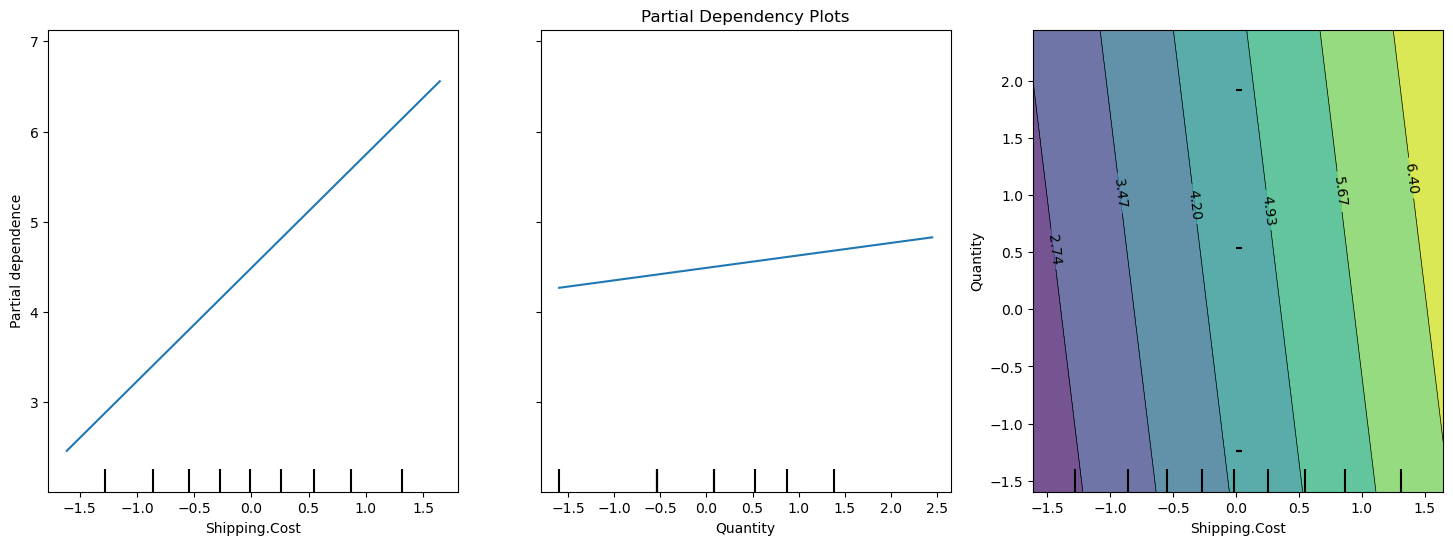

In [27]:
# Plot a standard partial dependence plot
from sklearn.inspection import PartialDependenceDisplay

# Define the features to plot
features = ['Shipping.Cost', 'Quantity', ('Shipping.Cost', 'Quantity')]
# Configure plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title("Partial Dependency Plots")
# Create the PartialDependenceDisplay
pdp_display = PartialDependenceDisplay.from_estimator(model_11, linear_train_X_condensed, features, ax=ax)

***Beeswarm Plot***

The beeswarm plot is ordered by feature importance. So 'Shipping.Cost' is the most important feature and 'Country_OTHER' is the least important, on average. Low feature value means it doesn't have much individual impact on the predicted output, while high feature value has lots of individual impact on the predicted output.

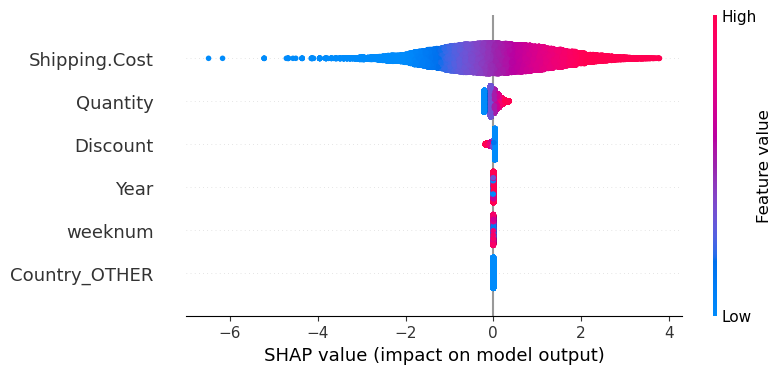

In [28]:
# Plot beeswarm graph
shap.plots.beeswarm(shap_values)

***Waterfall Plot***

The waterfall plot explains the impact each feature had on an individual prediction. It explains how we go from our expected output (average of all predicted values), to our current prediction. If we take the absolute value of each shap value, we can think of it more as a feature importance indicator.

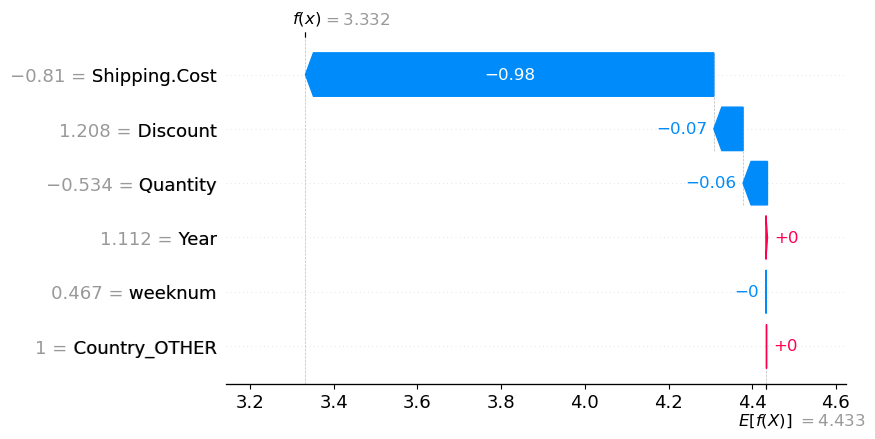

In [29]:
# Create waterfall plot
shap.plots.waterfall(shap_values[0])

# Model 2: XGBoost

To keep things simple, let's reuse the same train/test sets as was used in model 1.1.

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse

model_2 = XGBRegressor(n_estimators=25, subsample=0.8, colsample_bytree=0.8, random_state=2)
model_2.fit(linear_train_X_condensed, linear_train_y)
print(f"Train RMSE: {round(mse(linear_train_y, model_2.predict(linear_train_X_condensed), squared=False), 2)}")
print(f"Test RMSE: {round(mse(linear_test_y, model_2.predict(linear_test_X_condensed), squared=False), 2)}")

Train RMSE: 0.55
Test RMSE: 0.56


**Great!** So we have a better model than our linear regression model 1.1. Let's perform the same model interpretability techniques to see the additional non-linear patterns model 2 learned.

## Non-Linear Model Explainability

***Feature Importances*** is calculated for a single decision tree by the amount that each attribute's split point improves the performance measure, weighted by the number of observations the node is responsible for. In other words, summing the amount of splitting on each feature that minimizes the impurity (learned parameter that tells each tree how and when to split) across all splits in the tree.

<Axes: title={'center': 'Feature Importance'}>

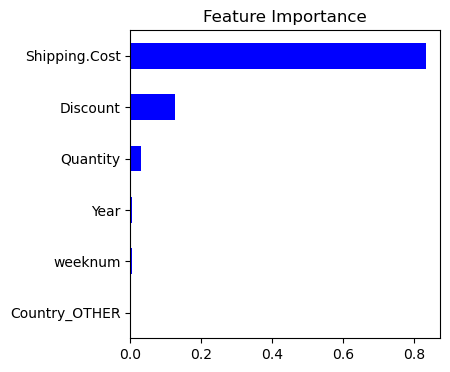

In [31]:
# XGBoost built-in feature importance
feature_importance = pd.DataFrame(model_2.feature_importances_, columns=['Importance'], 
                                  index=linear_train_X_condensed.columns)
feature_importance.sort_values('Importance').plot(kind='barh', title='Feature Importance', color='blue',
                                                  figsize=(4,4), legend=False)

<u>**NOTE:**</u> There is likely some data leakage in this example as 'Shipping.Cost' obviously tells us a great deal about our target variable: 'Sales'. However, again, the goal is to simply demonstrate model explainability techniques.

***Permutation Based Feature Importances*** is calculated by randomly shuffling the values of each feature and computing the changes in model performance. Features that have the highest impact on performance will have a higher score.

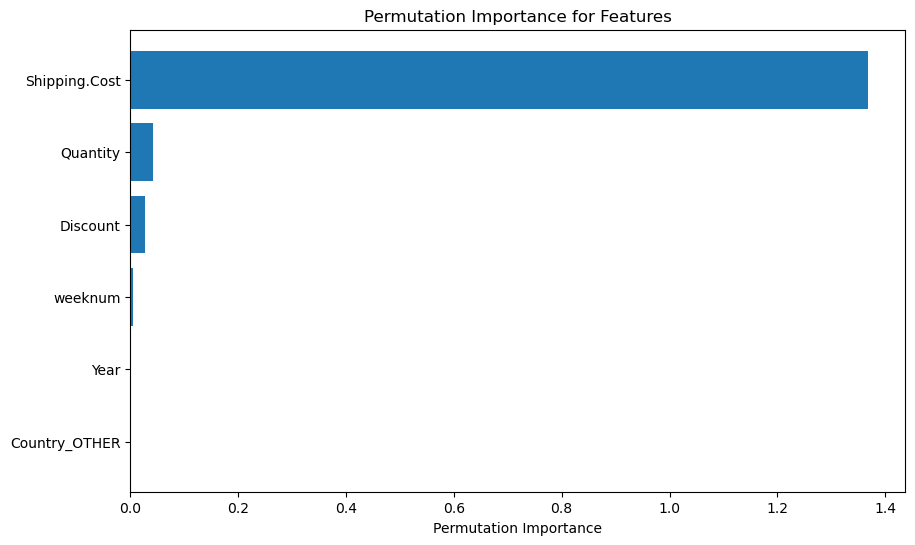

In [32]:
# Calculate the permutation feature importances
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model_2, linear_train_X_condensed, linear_train_y, n_repeats=30, random_state=2)

# Display feature importances
feature_importances = perm_importance.importances_mean
feature_names = linear_train_X_condensed.columns.tolist()
sorted_idx = (-feature_importances).argsort()[::-1]

# Plot permutation importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for Features')
plt.show()

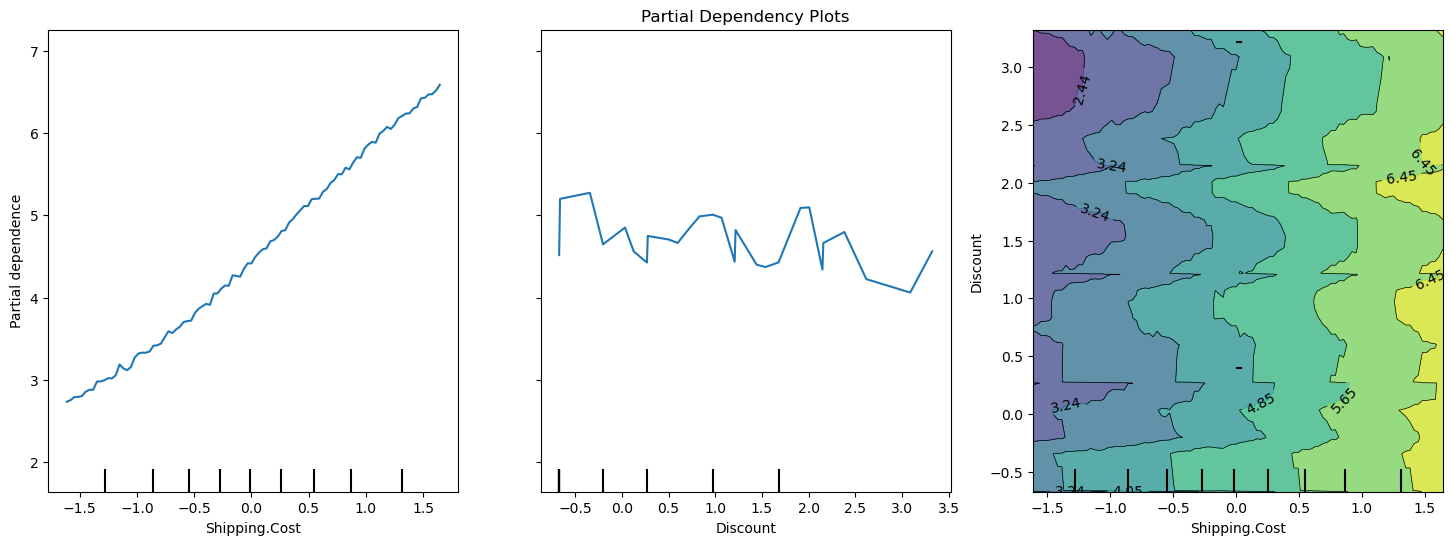

In [33]:
# Plot a standard partial dependence plot
from sklearn.inspection import PartialDependenceDisplay

# Define the features to plot
features = ['Shipping.Cost', 'Discount', ('Shipping.Cost', 'Discount')]
# Configure plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title("Partial Dependency Plots")
# Create the PartialDependenceDisplay
pdp_display = PartialDependenceDisplay.from_estimator(model_2, linear_train_X_condensed, features, ax=ax)

In [34]:
# Calculate the shap values for the training data
explainer_xgb = shap.Explainer(model_2.predict, linear_train_X_condensed)
shap_values_xgb = explainer_xgb(linear_train_X_condensed)

ExactExplainer explainer: 41033it [06:53, 96.74it/s]                            


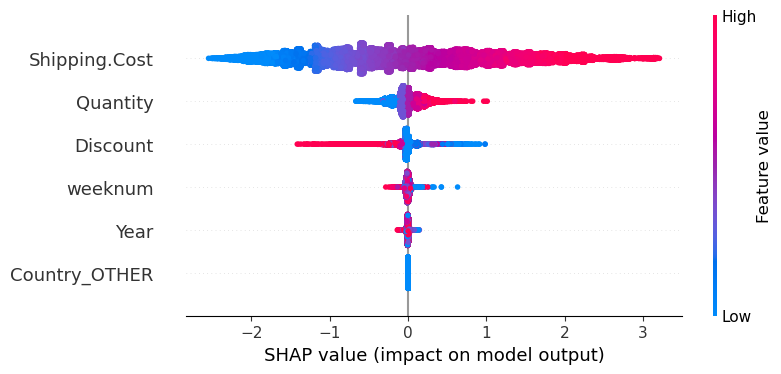

In [35]:
# Plot beeswarm graph
shap.plots.beeswarm(shap_values_xgb)

Random indice: 1957



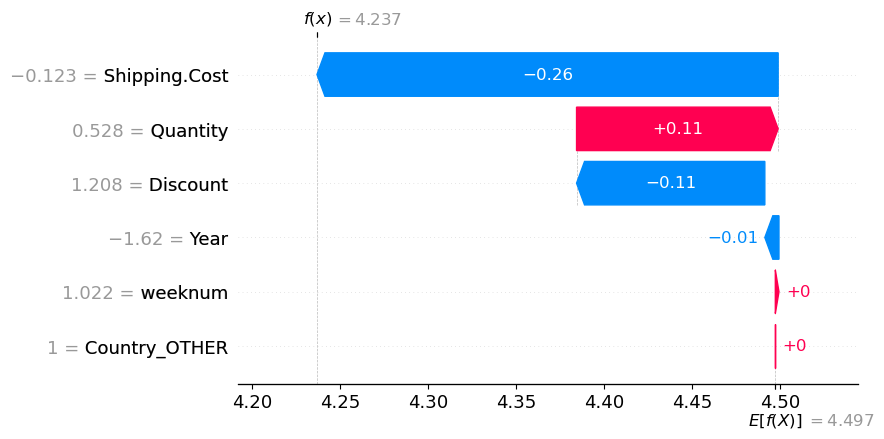

In [36]:
# Create waterfall plot to represent one instance
random_record = random.randrange(0, len(linear_train_X_condensed))
print(f"Random indice: {random_record}\n")
shap.plots.waterfall(shap_values_xgb[random_record])

# Create Final DF with Predictions and Shap Values

In [37]:
# Merge our predictions with our test set
forecast_df = pd.DataFrame(model_2.predict(linear_train_X_condensed), columns=['rawForecast'], index=linear_train_X_condensed.index)
forecast_df['transformedForecast'] = forecast_df.rawForecast
train_forecast = forecast_df.merge(o_train, how='inner', left_index=True, right_index=True)
shap_df = pd.DataFrame(shap_values.values, columns=linear_train_X_condensed.columns,
             index=linear_train_X_condensed.index).add_suffix('_shap')
train_forecast = train_forecast.merge(shap_df, how='inner', left_index=True, right_index=True)
# Create a transformed forecast to compare with original target variable
train_forecast['transformedForecast'] = train_forecast['transformedForecast'].apply(np.exp)
train_forecast.sort_index().head()

,rawForecast,transformedForecast,Category,City,Country,Customer.ID,Customer.Name,Discount,Market,ËÆ∞ÂΩïÊï∞,...,Sub.Category,Year,Market2,weeknum,Discount_shap,Quantity_shap,Shipping.Cost_shap,Year_shap,weeknum_shap,Country_OTHER_shap
1,2.988797,19.861778,Office Supplies,Los Angeles,United States,MV-174854,Mark Van Huff,0.0,US,1,...,Paper,2011,North America,4,0.037854,-0.058330,-1.645404,-0.004559,0.001263,0.0
3,3.959963,52.455399,Office Supplies,Los Angeles,United States,CS-121304,Chad Sievert,0.0,US,1,...,Paper,2011,North America,32,0.037854,-0.058330,-0.397173,-0.004559,-0.000172,0.0
4,2.722054,15.211534,Office Supplies,Los Angeles,United States,AP-109154,Arthur Prichep,0.0,US,1,...,Paper,2011,North America,40,0.037854,-0.205161,-1.378160,-0.004559,-0.000582,0.0
5,3.451200,31.538206,Office Supplies,Los Angeles,United States,JF-154904,Jeremy Farry,0.0,US,1,...,Paper,2011,North America,43,0.037854,0.027560,-0.910858,-0.004559,-0.000736,0.0
6,2.930686,18.740477,Office Supplies,Los Angeles,United States,WB-218504,William Brown,0.0,US,1,...,Paper,2011,North America,45,0.037854,0.027560,-1.486684,-0.004559,-0.000838,0.0


# Conclusion
Now we have a final dataframe output containing the original data, the forecast, and the shap values. In a real world setting, this dataframe can be written to a database (or perhaps just the predictions) and used to model in a reporting tool like Power BI or Tableau. <u>It's extremely powerful for businesses and organizations when machine learning insights can be understood outside of the context of a notebook.</u>

I hope you enjoyed this short demo of model explainability techniques! Thank you for taking the time to review!